# Expected Goals
This is a concept which translates position on the field to probability of scoring from the location.  The basis for the probability is the angle from the position to the posts of the goal.  The pattern has been validated based on actual shooting data from various leagues which demonstrate a very consistent outcome for actual shots taken, especially when removing outlier locations.

### Imports
The imports required to conduct the expected goals modeling is more in depth that the prior lessons.  This is driven by the data location and the statistical methods applied.

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening data
The Expected Goals (xG) model will use Wyscout data. To meet file size requirements for Github the files were stored in multiple smaller files. For this example the files were saved locally, so here they will be loaded from the directory.

In [2]:
#load data - store it in train dataframe
train = pd.DataFrame()
with open('./data/events_England.json') as f:
    data = json.load(f)
    train = pd.DataFrame(data)

In [3]:
# train['positions'][0][0]['x']
train.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172


## Preparing data
Exepcted goals model is built using only shots, so the data will be filtered for those events. 
- Query the data for only those actions for which the subEventName was Shot. **Note that this way penalties are excluded which wouldn’t be a case if we used only eventName.** 
- Store the coordinates of each shot transformed to 105 x 68 pitch. This will require some conversions. Treat the goal as x = 0. 
- Created C is an auxillary variable to help calculate the distance and angle. It is the distance from a point to the horizontal line through the middle of the pitch. 
- Calculate the distance to the goal as the distance on a Euclidean plane (see Distance in R2). Determine the angle using the formula from The Geometry of Shooting. 
- Maintain the data on if a goal was scored as part of the dataframe. It can be found in the tags column - if in this column exists {id: 101}.

In [7]:
# Filter dataframe for shots
shots = (train
 .query('subEventName == "Shot"')
 .assign(X = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100),
         Y = lambda df: df.positions.apply(lambda cell: cell[0]['y']* 68/100),
         C = lambda df: df.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100),
         Distance = lambda df: np.sqrt(df.X**2 + df.C**2),
         Angle = lambda df: np.where(np.arctan(7.32 * df["X"] / (df["X"]**2 + 
                                                                    df["C"]**2 - (7.32/2)**2)) > 0, 
                                     np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)), 
                                     np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)) 
                                     + np.pi),
         Goal = lambda df: df.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        )
)

In [8]:
shots.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0


## Plotting shot location
Investigating the relationship between shot location and goal location requires creation of a heat map of all shots from the 2017/18 Premier League season.  This will then be compared to the same heat map for the actual goals, and subsequently, the ratio of goals to shots taken will provide the initial view of expected goals.  This will then be converted into a mathmatical relationship based on the shot angle.

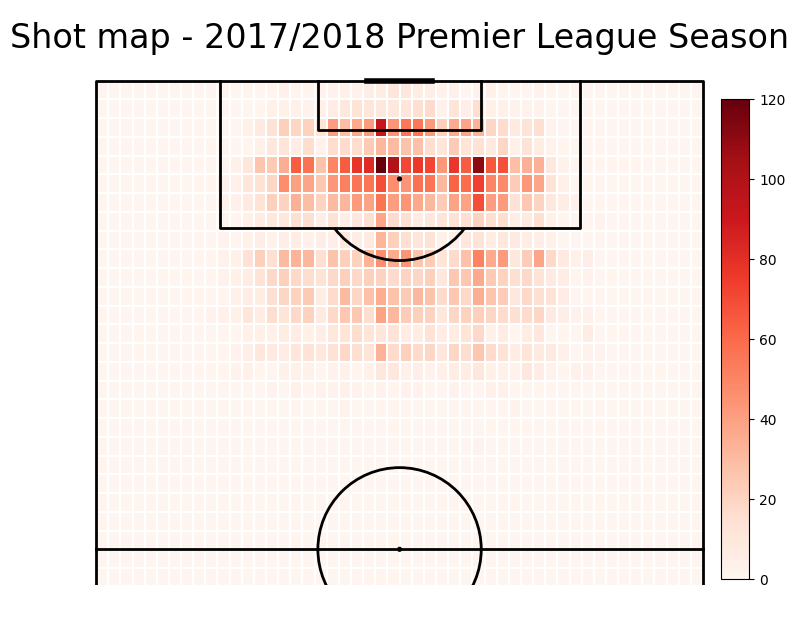

In [11]:
# plot pitch
pitch = VerticalPitch(line_color='black', half = True, 
                      pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=6,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# subtracting x from 105 but not y from 68 because of inverted Wyscout axis
# calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# make heatmap
pcm = pitch.heatmap(bin_statistic_shots, 
                    ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

# make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 24)
plt.show()

## Plotting goal location
Continuing the process to depict the location where goals were scored in open play.  To achieve this, the same shots approach will be used, however it will be filtered to show only opportunities which resulted in goals.

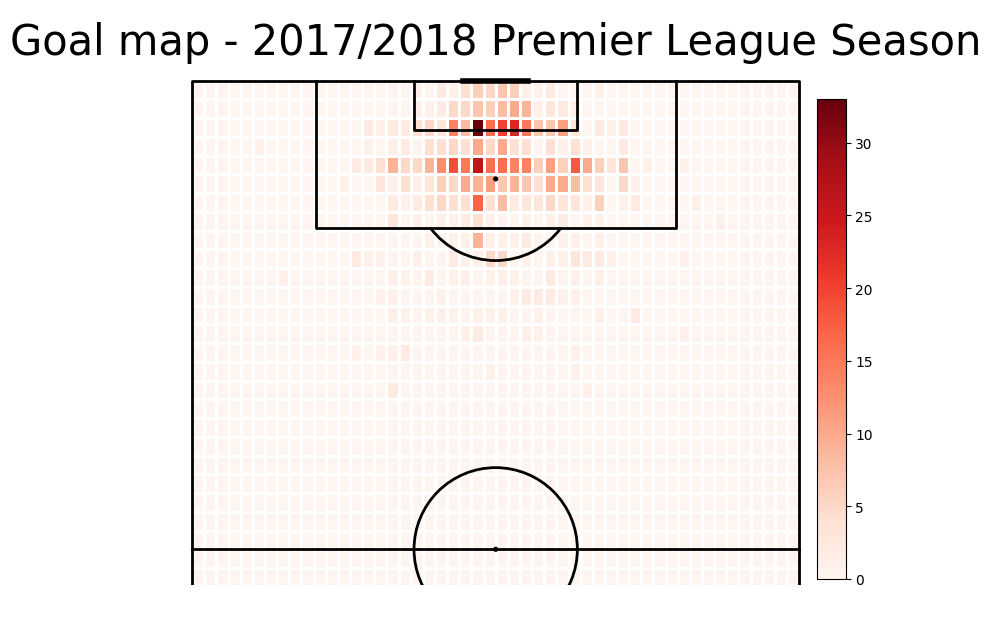

In [12]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=6,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

## Plotting the probability of scoring a goal given the location
Based on these two pieces of information it is possible to calculate the proportion of goals scored from each bin to number of shots from that location.  This provides a measured view of the expected goal model.

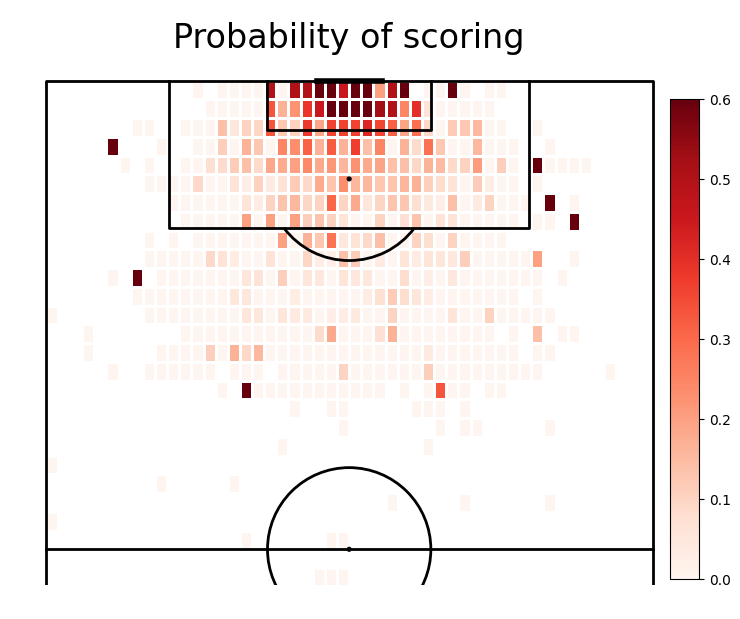

In [13]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, 
                      pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=6,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)

#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]

#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 24)
plt.show()